In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"
chunk_dict={"time":50, "ncol":2000, "lev":50}

In [3]:
# m = "UM"
# xr.open_dataset(ap.get_fldmean_file(m, region, "cltotal")).cltotal
# da = xr.open_dataset(ap.TWP+"mean/fldmean_TWP_3D_SHiELD_zg_20200130-20200228.nc").zg.mean(axis=(0,2))
# ds = xr.Dataset({"zg":da}, attrs={"long_name":"spatiotemporal mean of geopotential height", "units":"m"})
# ds.to_netcdf(ap.TWP+"mean/xytmean_TWP_3D_SHiELD_zg_20200130-20200228.nc")

In [18]:
models=["SCREAM","ARP","ICON","UM","SHiELD"]
var="cl_5e-7kgm-3"
varw = "totalwater"
# models=["SCREAM", "SAM", "GEOS", "ICON", "UM", "ARP", "SHiELD"] # 
# var="cl_5e-7kgkg-1"
# varw="cltotal"

## create dictionaries with models as keys for each variable 
## temp & water vapor content
# ta_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "ta")).ta.median(axis=(0,2,3)) for m in models]))
# hus_dict = dict(zip(models, [xr.open_dataset(ap.get_fldmean_file(m, region, "hus")).hus.median(axis=(0,2,3)) for m in models]))
### SAM has qv in g/kg - convert to kg/kg
# hus_dict["SAM"] = hus_dict["SAM"]/1000

cltotal_dict = {}
cl_dict = {}
z_dict = {}
for m in models:
    print(m)
    if (m=="SAM") or (m=="UM"):
        axtup = (0,2,3)
        axtup2 = axtup
    else: # elif (m=="ARP") or (m=="SHiELD"):
        axtup = (0,2)
        axtup2 = axtup
    # else:
    #     axtup = (0,2)
    #     axtup2 = (0,2,3)
    ## get total frozen hydrometeors & cloud fraction
    cltotal_dict[m] = xr.open_dataset(ap.get_fldmean_file(m, region, varw))[varw].mean(axis=axtup)
    cl_dict[m] = xr.open_dataset(ap.get_fldmean_file(m, region, var)).cl.mean(axis=axtup2)
    if (m=="SCREAM") or (m=="ICON") or (m=="ARP") or (m=="UM"):
        cltotal_dict[m] = cltotal_dict[m][1:]
        cl_dict[m] = cl_dict[m][1:]        
    ## get height variables
    if m=="SAM":
        z_dict[m] = cl_dict["SAM"].z.rename({"z":"zg"})
        cltotal_dict["SAM"] = cltotal_dict["SAM"]/1000
    else:
        z_dict[m] = xr.open_dataset(ap.get_xytmean_file(m,"TWP","zg")).zg
    print(m, cltotal_dict[m].shape, cl_dict[m].shape, z_dict[m].shape)

## add in observations - DARDAR
ds = xr.open_dataset("/work/bb1153/b380883/TWP/twp.nc")
cltotal_dict["DARDAR"] = ds.iwc.mean(axis=0)/1000
cl_dict["DARDAR"] = np.where(ds.iwc>5e-4,1,0).mean(axis=0)
models=["DARDAR"]+models
z_dict["DARDAR"] = ds.height
print("DARDAR", cltotal_dict["DARDAR"].shape, cl_dict["DARDAR"].shape, z_dict["DARDAR"].shape)
## add in observations - CCCM
ds = xr.open_dataset("/work/bb1153/b380883/TWP/CCCM_dTWP_2007-2010.nc")
cl_dict["CCCM"] = ds["Cloud fraction (CALIPSO-CloudSat)"].mean(axis=0)
cltotal_dict["CCCM"] = (ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]+\
                        ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"]).mean(axis=0)/1000
models=["CCCM"]+models
z_dict["CCCM"] = ds.alt*1000
print("CCCM", cltotal_dict["CCCM"].shape, cl_dict["CCCM"].shape, z_dict["CCCM"].shape)

# big_dict = {"cltotal":cltotal_dict, "cl":cl_dict, "z":z_dict}
print("...done")

SCREAM
SCREAM (127,) (127,) (127,)
ARP
ARP (59,) (59,) (59,)
ICON
ICON (76,) (76,) (76,)
UM
UM (54,) (54,) (54,)
SHiELD
SHiELD (79,) (79,) (79,)
DARDAR (436,) (436,) (436,)
CCCM (92,) (92,) (92,)
...done


In [19]:
print(" model \t  14km \t \t  18km \t \t n")
print("-------------------------------------------------")

for m in models:
    z = z_dict[m].values
    i14 = np.argmin(abs(z-14000))
    i18 = np.argmin(abs(z-18000))
    print(m+"\t {} {:.2f} \t {} {:.2f} \t {}".format(i14, z[i14], i18, z[i18], (i18-i14)))
    

 model 	  14km 	 	  18km 	 	 n
-------------------------------------------------
CCCM	 22 13920.00 	 5 18000.00 	 -17
DARDAR	 185 13980.00 	 118 18000.00 	 -67
SCREAM	 47 13909.74 	 29 17910.05 	 -18
ARP	 12 13944.95 	 3 18133.93 	 -9
ICON	 30 14015.83 	 22 18167.51 	 -8
UM	 43 14079.88 	 49 18026.52 	 6
SHiELD	 22 14064.95 	 14 18157.68 	 -8


## Cloud fraction & total cloud condensate

SCREAM uses 1e-5 kg/kg for their cloud mask - to be consistent we will use this as well.

In [20]:
## for comparison purposes
# cl_ge = xr.open_dataset("/work/bb1153/b380883/TWP/mean/fldmean_TWP_3D_GEOS_cl_modeloutput_20200130-20200228.nc").cl.mean(axis=(0,2,3))

# plt.plot(cl_ge, z_dict["GEOS"], color=colors["GEOS"], label=m, lw=2)
# plt.plot(cl_dict["GEOS"], z_dict["GEOS"], color=colors["GEOS"], label=m, lw=1)
# plt.ylim([0,20000])
# plt.show()

CCCM
DARDAR
SCREAM
ARP
ICON
UM
SHiELD


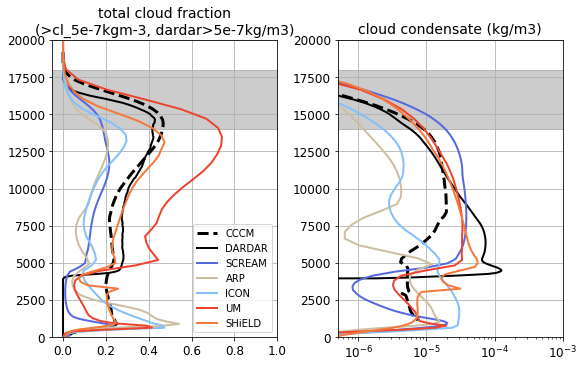

In [23]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(8,5), constrained_layout=True)
emph="CCCM" # specific which model to emphasize by making the line thicker

#### plot each model ####
for i,m in enumerate(models):
    print(m)
    if (m=="CCCM") or (m=="DARDAR"):
        mc = "OBS"
    else:
        mc=m
    if emph==m:
        ls = "--"
        lw = 3
    else:
        ls = "-"
        lw = 2
    ax.plot(cl_dict[m], z_dict[m], color=colors[mc], label=m, linestyle=ls, lw=lw)
    axt.plot(cltotal_dict[m], z_dict[m], color=colors[mc], linestyle=ls, lw=lw)
    
    ## Add in freezing level
    # i_frz = np.argmin(abs(ta_dict[m].values-273))
    # ax.scatter(cl_dict[m][i_frz], z_dict[i_frz], color=colors[mc], alpha=0.6, marker="s")
    # axt.scatter(cltotal_dict[m][i_frz], z_dict[i_frz], color=colors[mc], alpha=0.6, marker="s")

## add in the TTL as a shaded region, title, and grid lines
ax.fill_between([-0.1,1],14000,18000,color="k",alpha=0.2)
ax.set_title("total cloud fraction\n(>{}, dardar>5e-7kg/m3)".format(var), fontsize=14)
ax.grid()
axt.fill_between([-1,0.6],14000,18000,color="k",alpha=0.2)
units = "kg/kg" if varw=="cltotal" else "kg/m3"
axt.set_title("cloud condensate ({})".format(units), fontsize=14)
axt.grid()

# set axis properties
ax.set_xlim([-0.05,1])
ax.set_ylim([0,20000])
ax.tick_params(labelsize=12)
axt.set_xlim([5e-7,1e-3])
axt.set_xscale("log")
axt.set_ylim([0, 20000])
axt.tick_params(labelsize=12)

ax.legend(loc="lower right")

# save figure
plt.savefig("../plots/TWP/TWP_3D_{}_{}.png".format(var, varw), dpi=120)

plt.show()